In [1]:
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import scipy
import copy
import sys
import os
from typing import Optional, Union, Sequence, Mapping, List, Set
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from matplotlib.lines import Line2D

import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_shapes,filter_df
from quantum_kernel.code.kernel_measures.kernel_geometry import purity_average, purity_of_average
from quantum_kernel.code.kernel_measures.eigenvalue_scaling import get_eigenvalue_scaling,compute_dataframe_kernel_eigenvalues

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 18}

rc('font', **font)

tqdm.pandas()
warnings.filterwarnings("ignore")


In [2]:
# Get kernel results for the different ml models and dataset.d
dfs = {}
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/final_gennorm",'Sparse_IQP'),
]
cols_to_drop=['qkern_matrix_train', 'args', 'K_train_time', 'rdms', 
'samples', 'mu','sigma', 'outpath','seed', 'projected']
for folder,prefix in folders:
    if prefix in dfs:
        temp = aggregate_shapes(folder,prefix,cols_to_drop=cols_to_drop)
        dfs[prefix] = pd.concat([dfs[prefix], temp])
    else:
        dfs[prefix] = aggregate_shapes(folder,prefix)


In [3]:
save_folder='/mnt/c/Users/lslat/Data/QK_project/results/figs/'

In [4]:
iqp_df=dfs['Sparse_IQP']

In [6]:
sys.getsizeof(iqp_df)

512644

In [8]:
iqp_df.columns

Index(['qkern_matrix_train', 'args', 'K_train_time', 'rdms', 'samples', 'mu',
       'sigma', 'outpath', 'dataset_dim', 'scaling_factor',
       'int_scaling_factor', 'density', 'beta', 'seed', 'projected',
       'kernel_eigenvalues'],
      dtype='object')

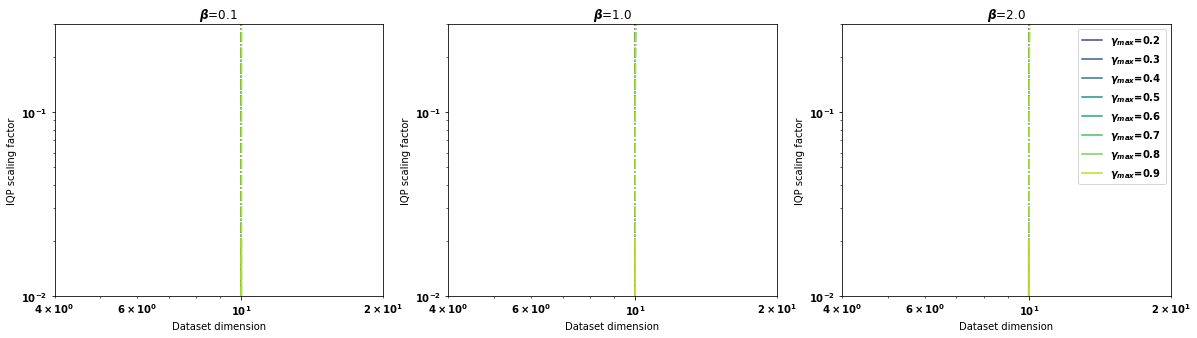

In [ ]:
colormap=cm.viridis
gammas=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
test_sfs=set(iqp_df.scaling_factor)
betas=[0.1,1.0,2.0]
fig, axs = plt.subplots(1,len(betas),figsize=(20,5))
for i,beta in enumerate(betas):
    filter={'beta': beta}
    new_df=compute_dataframe_kernel_eigenvalues(iqp_df,filter,k=3)

    ax=axs[i]
    quantum_df=new_df[(new_df['density']!=0)]
    classical_df=new_df[(new_df['density']==0)]

    lines=[]
    handles=[]
    for gamma in gammas:
        test_sfs=list(set(quantum_df.scaling_factor))
        test_sfs.sort()
        q_curve=get_eigenvalue_scaling(quantum_df,gamma,test_sfs)
        test_sfs=list(set(classical_df.scaling_factor))
        test_sfs.sort()
        c_curve=get_eigenvalue_scaling(classical_df,gamma,test_sfs)
        label=r'$\gamma_{max}$='+str(gamma)
        color=colormap(gamma)
        line=ax.errorbar(q_curve[:,0],q_curve[:,1],label=label,color=color)
        _=ax.errorbar(c_curve[:,0],c_curve[:,1],color=color,ls='-.')
        lines.append(line[0])
        handles.append(label)

    ax.set_xlabel('Dataset dimension')
    ax.set_ylabel('IQP scaling factor')
    ax.set_xlim([4,20])
    ax.set_ylim([0.01,0.3])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(r'$\beta$='+str(beta))

ax.legend(lines,handles,bbox_to_anchor=(1,1))
#fig.savefig(f'{save_folder}IQP_fixed_gamma_decay_curves_plots.pdf')

In [ ]:
test_sfs=list(set(classical_df.scaling_factor))
test_sfs.sort()
c_curve=get_eigenvalue_scaling(classical_df,gamma,test_sfs)

In [ ]:
beta=1.0
filter={'beta': beta}
new_df=compute_dataframe_kernel_eigenvalues(iqp_df,filter,k=3)

classical_df=new_df[(new_df['density']==0)]

test_sfs=list(set(classical_df.scaling_factor))
test_sfs.sort()
c_curve=get_eigenvalue_scaling(classical_df,gamma,test_sfs)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
gamma=0.2
fitted_points=[]
lam_df=classical_df[(classical_df['scaling_factor']==test_sfs[5])]
#note xp and yp are different than lambda vs. N normally plotted because we want to interpolate to find the x intercept.
xp=lam_df.dataset_dim
xp=np.array(list(set(xp.values)))
#sort for interpolation
points=[]
for x in xp:
    ys=lam_df[(lam_df['dataset_dim']==x)].apply(lambda x: max(x.kernel_eigenvalues),axis=1).values
    xs=np.array(len(ys)*[x])
    new_points=list(zip(xs,ys))
    points=points+new_points
points=np.array(points) 
#fit exponential decay to the points.
x=points[:,0].reshape(-1,1)
y=points[:,1].reshape(-1,1)

reg=LinearRegression(fit_intercept=True).fit(x,np.log(y))
#solution np.log(y)=a+b*x -> y=exp(a)*exp(b*x)
#now solve for x, np.log(gamma) = a+b*x -> x = (np.log(gamma)-a)/b
ypred=(np.log(gamma)-reg.intercept_[0])/reg.coef_[0,0]
yerr=()
fitted_points.append((ypred,test_sfs[0]))

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.OLS(y, X).fit() 
model.bse 

NameError: name 'X' is not defined